### Generic Movement Detection with OpenCV Background Subtractor

Let's track objects that are moving in a static camera scene using OpenCV Background Subtractor

In [1]:
# video ref: https://www.pexels.com/video/road-systems-in-montreal-canada-for-traffic-management-of-motor-vehicles-3727445/

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

In [4]:
import sys
sys.path.append('C:/Users/Mafeus/Desktop/Git_Repos/OpenCV')
import OpCV_Utils

In [77]:
def drawBoundingBox(img, x, y, w, h, text, color):
    
    # add litle background to class name info:
    backg = np.full((img.shape), (0,0,0), dtype=np.uint8)
    cv2.putText(backg, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
    fx,fy,fw,fh = cv2.boundingRect(backg[:,:,2])
                
    # Draw obj bbox:
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2) 
    cv2.rectangle(img, (fx, fy), (fx + fw, fy + fh), color, -1) 
    cv2.rectangle(img, (fx, fy), (fx + fw, fy + fh), color, 3) 
    cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)

In [151]:
# Create Background Subtractor Object:
movement_detector = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=40)

########################################### Video Stream Loop #######################################################
#####################################################################################################################

# Load Video:
video_path = 'traffic3.mp4'
cap = cv2.VideoCapture(video_path)
video_fps = cap.get(cv2.CAP_PROP_FPS)
des_resolution = (640,480)

while True:
    
    # Get Frame:
    start = time.time()
    success, frame = cap.read()
    
    if not success:
        print('Server OFF')
        
        # Loop:
        cap = cv2.VideoCapture(video_path)
        success, frame = cap.read()

        break
        
    frame = cv2.resize(frame, des_resolution)
    
    # Obj Detection:
    
    detection_mask = movement_detector.apply(frame)
    
    _, detection_mask = cv2.threshold(detection_mask, 250, 255, cv2.THRESH_BINARY)
                
    contours, hiearchy = cv2.findContours(detection_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
    detection_mask = cv2.cvtColor(detection_mask, cv2.COLOR_GRAY2BGR)   
    
    # Objs in Scene Counter:
    i = 0
    
    for c in contours:
            
            # Get contour Area:
            area = cv2.contourArea(c)
            
            # Get contour perimiter (closed):
            perimeter = cv2.arcLength(c, True)
                
            # Get contour approx corner points:
            approxCorners = cv2.approxPolyDP(c, 0.02*perimeter, True)
            
            bbox = cv2.boundingRect(approxCorners)
                        
            if (200 < area < 800) & (perimeter < 1000):
                
                i +=1
                                
                cv2.drawContours(detection_mask, [c], -1, (0, 0, 255), 2)
                
                x, y, w, h = bbox
                
                text = 'Obj: {}'.format(i)
                
                drawBoundingBox(detection_mask, x, y, w, h, text, (255,0,0))                
                
    # Stack Output:                                        
    frame = OpCV_Utils.stackImgs([[frame, detection_mask]], sep_lines=True, scale=0.8)
            
    ###############################################################################################################
    ############################################# Processing ######################################################
    ###############################################################################################################
    
    ###############################################################################################################
    # Display FPS:
    end = time.time()

    frame_time = (end - start) + 0.0001
    fps = np.floor(1/frame_time)
        
    if (fps > video_fps):
        time.sleep(1/video_fps)
        fps = video_fps
                    
    cv2.putText(frame, "FPS: {}".format(fps), (30,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    ###############################################################################################################
    # Keyboard Controls:
    key = cv2.waitKey(1) or 0xff   
    if key == ord('k'):
        break
    ###############################################################################################################
    # Show Frame:
    cv2.imshow("Video Stream", frame)
    ###############################################################################################################
    
cv2.destroyAllWindows()
cap.release()

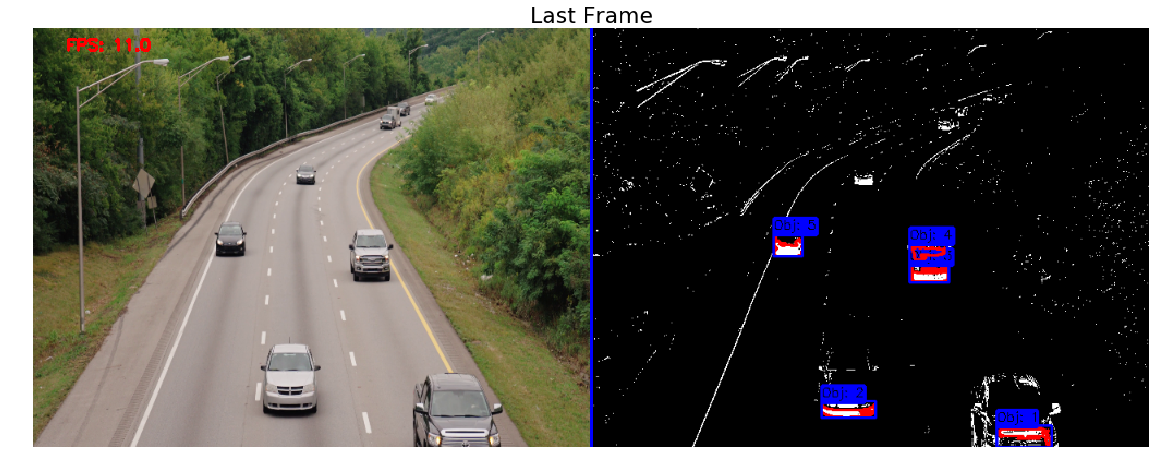

In [152]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
OpCV_Utils.show_single_img_plt(frame, 'Last Frame', fig_size = (20,20))